In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.set_default_tensor_type('torch.cuda.FloatTensor')
sns.set_style('whitegrid')

%matplotlib inline

In [2]:
def poisson_entropy_mc(log_lmbd, t_max, temp=None, batch_size=1, max_len=1000, seed=None):
    """Approximate the entropy of a homogeneous Poisson process with Monte Carlo.
    
    See Section 4.1 of the paper.
    
    Args:
        log_lmbd: Logarithm of the intensity, float
        t_max: Length of the interval [0, T]
        temp: Temperature to use in differentiable relaxation or None
        batch_size: Number of MC samples to use
        max_len: Maximum length of generated sequences
        seed: Random seed
    
    Returns:
        entropy: Estimated entropy
    """
    if seed is not None:
        torch.manual_seed(seed)
    long_enough = False
    # Make sure that enough samples are generated
    while not long_enough:
        # Sample from a HPP with unit rate
        z = torch.empty(batch_size, max_len).exponential_().cumsum(-1)
        lmbd = log_lmbd.exp()
        t = z / lmbd
        long_enough = (t[..., -1].min() > t_max).item()
        max_len *= 2
    # Count the number of events t_i that happen before t_max
    if temp is None:
        mask = t < t_max
    else:
        mask = torch.sigmoid((t_max - t) / temp)
    num_events = mask.sum(-1)
    log_like = num_events * log_lmbd - lmbd * t_max
    return log_like.mean()

# Visualize the discontinuities

In [3]:
log_lmbd = torch.linspace(0.1, 5, 1000).log()

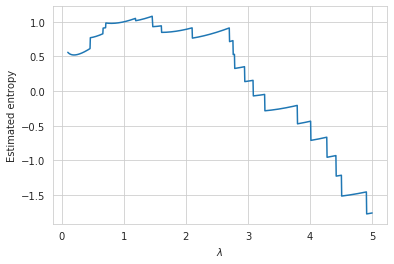

In [4]:
# Change the temperature to see its effect on the relaxation, try values 1e-1, 1e-2, 1e-3
# temp = 0 or temp = None corresponds to no relaxation
temp = 0
batch_size = 5
t_max = 1
seed = 123

losses = []
for l in log_lmbd:
    losses.append(poisson_entropy_mc(l, t_max, seed=seed, batch_size=batch_size, temp=temp).item())

fig, axes = plt.subplots()
axes.plot(log_lmbd.exp().cpu().numpy(), -np.array(losses))
axes.set(xlabel=r'$\lambda$', ylabel=r'Estimated entropy')
plt.show()

# Maximize the entropy with gradient ascent

Training with temperature = 0.1
  Epoch    0, entropy = -2.10, scale = 4.437
  Epoch  250, entropy = 0.94, scale = 1.346
  Epoch  500, entropy = 1.00, scale = 1.061
  Epoch  750, entropy = 1.00, scale = 1.007
  Epoch 1000, entropy = 1.00, scale = 1.002

Training with temperature = 0.0001
  Epoch    0, entropy = -2.25, scale = 4.437
  Epoch  250, entropy = 0.73, scale = 1.660
  Epoch  500, entropy = 0.95, scale = 1.190
  Epoch  750, entropy = 1.00, scale = 1.063
  Epoch 1000, entropy = 1.00, scale = 1.021

Training with temperature = None
  Epoch    0, entropy = -2.10, scale = 4.527
  Epoch  250, entropy = -1.03, scale = 3.579
  Epoch  500, entropy = -0.44, scale = 2.998
  Epoch  750, entropy = -1.01, scale = 3.442
  Epoch 1000, entropy = -1.15, scale = 3.663



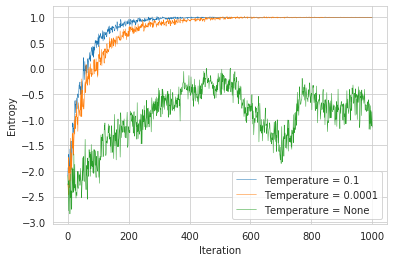

In [5]:
batch_size = 200

for temp in [1e-1, 1e-4, None]:
    print(f'Training with temperature = {temp}')
    learnable_log_lmbd = nn.Parameter(torch.Tensor([1.5]))
    opt = torch.optim.Adam([learnable_log_lmbd], lr=1e-2)
    history = []
    for epoch in range(1001):
        opt.zero_grad()
        loss = poisson_entropy_mc(learnable_log_lmbd, t_max, temp=temp, batch_size=batch_size)
        loss.backward()
        history.append(-loss.item())
        opt.step()
        if epoch % 250 == 0:
            rate = learnable_log_lmbd.exp().item()
            print(f'  Epoch {epoch:4d}, entropy = {-loss.item():.2f}, scale = {rate:.3f}')
    print()
    plt.plot(history, label=f'Temperature = {temp}', linewidth=0.5)
plt.xlabel('Iteration')
plt.ylabel('Entropy')
plt.legend()
plt.show()